# Comprehensive Wordle Algorithm Analysis

This notebook provides a complete statistical analysis of our **Information-First Wordle Solving Algorithm**.

## Algorithm Overview

Our algorithm uses an **expected value optimization** approach that:
- Prioritizes **information gathering** over direct guessing
- Tests new letters to maximize knowledge gained
- Uses the entire dictionary for information guesses
- Only recommends possible answers when certain

---

In [9]:
# Cell 1 - Setup and Data Loading
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import random
from collections import defaultdict, Counter
import statistics

# Load the word list
with open('words.txt', 'r') as f:
    words = [word.strip().upper() for word in f.readlines() if len(word.strip()) == 5]

print(f"Loaded {len(words):,} five-letter words from dictionary")
print(f"Sample words: {words[:10]}")

Loaded 14,855 five-letter words from dictionary
Sample words: ['AAHED', 'AALII', 'AAPAS', 'AARGH', 'AARTI', 'ABACA', 'ABACI', 'ABACK', 'ABACS', 'ABAFT']


In [12]:
# Cell 2 - Complete Algorithm 
import statistics
from collections import defaultdict, Counter

class WordleSolver:
    def __init__(self, word_list):
        self.all_words = [word.upper() for word in word_list if len(word) == 5]
        self.reset_game()
    
    def reset_game(self):
        """Reset solver state for a new game"""
        self.possible_words = self.all_words.copy()
        self.guess_history = []
        self.tested_letters = set()
        self.known_letters = set()
        self.excluded_letters = set()
    
    def update_letter_tracking(self, guess, result):
        """Track which letters have been tested and their status"""
        for i, letter in enumerate(guess):
            self.tested_letters.add(letter)
            
            if result[i] in ['green', 'yellow']:
                self.known_letters.add(letter)
            elif result[i] == 'grey':
                # Only exclude if letter doesn't appear as green/yellow elsewhere
                appears_elsewhere = any(
                    result[j] in ['green', 'yellow'] and guess[j] == letter
                    for j in range(5) if j != i
                )
                if not appears_elsewhere:
                    self.excluded_letters.add(letter)
    
    def is_word_compatible(self, word, guess, result):
        """Check if a word is compatible with a guess result"""
        word_letters = list(word)
        guess_letters = list(guess)
        
        # Check each position
        for i in range(5):
            if result[i] == 'green':
                if word_letters[i] != guess_letters[i]:
                    return False
            elif result[i] == 'yellow':
                if word_letters[i] == guess_letters[i]:
                    return False
                if guess_letters[i] not in word:
                    return False
            elif result[i] == 'grey':
                # Check if letter appears as green/yellow elsewhere
                has_yellow_or_green = any(
                    result[j] in ['yellow', 'green'] and guess_letters[j] == guess_letters[i]
                    for j in range(5)
                )
                if not has_yellow_or_green and guess_letters[i] in word:
                    return False
        
        # Additional check for yellow letters - count constraints
        for i in range(5):
            if result[i] == 'yellow':
                letter = guess_letters[i]
                guess_count = sum(1 for j in range(5) 
                                if guess_letters[j] == letter and result[j] in ['yellow', 'green'])
                word_count = word.count(letter)
                if word_count < guess_count:
                    return False
        
        return True
    
    def get_result_pattern(self, guess, answer):
        """Calculate what result pattern a guess would give for an answer"""
        result = ['grey'] * 5
        answer_letters = list(answer)
        guess_letters = list(guess)
        used_answer_indices = set()
        
        # First pass: mark greens
        for i in range(5):
            if guess_letters[i] == answer_letters[i]:
                result[i] = 'green'
                used_answer_indices.add(i)
        
        # Second pass: mark yellows
        for i in range(5):
            if result[i] == 'grey':
                letter = guess_letters[i]
                for j in range(5):
                    if (j not in used_answer_indices and 
                        answer_letters[j] == letter):
                        result[i] = 'yellow'
                        used_answer_indices.add(j)
                        break
        
        return result
    
    def calculate_expected_value(self, guess):
        """Calculate expected information gain for a guess"""
        if len(self.possible_words) <= 1:
            return 0
        
        result_groups = defaultdict(list)
        
        # Group possible answers by result pattern
        for answer in self.possible_words:
            pattern = self.get_result_pattern(guess, answer)
            key = ''.join(pattern)
            result_groups[key].append(answer)
        
        # Calculate expected remaining words
        expected_remaining = sum(
            (len(group) / len(self.possible_words)) * len(group)
            for group in result_groups.values()
        )
        
        # Base information gain
        info_gain = len(self.possible_words) - expected_remaining
        
        # Bonus for testing new letters
        guess_letters = set(guess)
        new_letters = guess_letters - self.tested_letters
        info_gain += len(new_letters) * 2
        
        # Penalty for repeated letters (unless few options)
        unique_letters = len(guess_letters)
        if unique_letters < 5 and len(self.possible_words) > 10:
            info_gain -= (5 - unique_letters) * 1.5
        
        # Penalty for using excluded letters
        excluded_used = len(guess_letters & self.excluded_letters)
        info_gain -= excluded_used * 5
        
        return info_gain
    
    def find_distinguishing_words(self):
        """Find words that help distinguish between remaining options"""
        if len(self.possible_words) != 2:
            return self.all_words
        
        word1, word2 = self.possible_words
        diff_letters = set()
        
        for i in range(5):
            if word1[i] != word2[i]:
                diff_letters.add(word1[i])
                diff_letters.add(word2[i])
        
        return [word for word in self.all_words 
                if (any(letter in word for letter in diff_letters) and
                    len(set(word)) == 5)]  # Prefer unique letters
    
    def find_best_guess(self):
        """Find the optimal next guess"""
        if not self.possible_words:
            return None
        
        if len(self.possible_words) == 1:
            return self.possible_words[0]
        
        # Choose guess pool based on game state
        if len(self.possible_words) > 50:
            guess_pool = self.all_words[:1000]  # Limit for performance
        elif len(self.possible_words) > 2:
            guess_pool = self.all_words
        else:
            guess_pool = self.find_distinguishing_words()
            if not guess_pool:
                return self.possible_words[0]
        
        best_guess = None
        best_score = -1
        
        for guess in guess_pool:
            score = self.calculate_expected_value(guess)
            if score > best_score:
                best_score = score
                best_guess = guess
        
        return best_guess or self.possible_words[0]
    
    def make_guess(self, guess, result):
        """Process a guess and its result"""
        self.guess_history.append((guess, result))
        self.update_letter_tracking(guess, result)
        
        # Filter possible words
        self.possible_words = [
            word for word in self.possible_words
            if self.is_word_compatible(word, guess, result)
        ]
    
    def solve_word(self, target_word, max_guesses=6):
        """Solve a specific word and return metrics"""
        self.reset_game()
        guesses = []
        
        for guess_num in range(max_guesses):
            if len(self.possible_words) == 1 and self.possible_words[0] == target_word:
                # Found the answer
                return {
                    'success': True,
                    'guesses': guess_num,
                    'guess_history': guesses,
                    'final_words_remaining': 1
                }
            
            best_guess = self.find_best_guess()
            if not best_guess:
                break
            
            result = self.get_result_pattern(best_guess, target_word)
            guesses.append((best_guess, result))
            
            if best_guess == target_word:
                return {
                    'success': True,
                    'guesses': guess_num + 1,
                    'guess_history': guesses,
                    'final_words_remaining': 1
                }
            
            self.make_guess(best_guess, result)
        
        return {
            'success': False,
            'guesses': max_guesses,
            'guess_history': guesses,
            'final_words_remaining': len(self.possible_words)
        }

print("Complete algorithm classes loaded successfully")

Complete algorithm classes loaded successfully


In [13]:
# Cell 3 - Quick Test on Sample Words
solver = WordleSolver(words)

test_cases = ['ABOUT', 'CRANE', 'LIGHT', 'WORLD', 'HOUSE']
print("Quick test on sample words:")
print("-" * 40)

for word in test_cases:
    if word in words:
        result = solver.solve_word(word)
        print(f"{word}: {result['guesses']} guesses - {result['success']}")
        for i, (guess, pattern) in enumerate(result['guess_history']):
            print(f"  {i+1}. {guess} -> {pattern}")
        print()
    else:
        print(f"{word}: Not in dictionary")

Quick test on sample words:
----------------------------------------
ABOUT: 3 guesses - True
  1. AEROS -> ['green', 'grey', 'grey', 'yellow', 'grey']
  2. CLINT -> ['grey', 'grey', 'grey', 'grey', 'green']
  3. BUMPH -> ['yellow', 'yellow', 'grey', 'grey', 'grey']

CRANE: 4 guesses - True
  1. AEROS -> ['yellow', 'yellow', 'yellow', 'grey', 'grey']
  2. BADGE -> ['grey', 'yellow', 'grey', 'grey', 'green']
  3. PITCH -> ['grey', 'grey', 'grey', 'yellow', 'grey']
  4. FLUNK -> ['grey', 'grey', 'grey', 'green', 'grey']

LIGHT: 3 guesses - True
  1. AEROS -> ['grey', 'grey', 'grey', 'grey', 'grey']
  2. AUNTY -> ['grey', 'grey', 'grey', 'yellow', 'grey']
  3. FILCH -> ['grey', 'green', 'yellow', 'grey', 'yellow']

WORLD: 3 guesses - True
  1. AEROS -> ['grey', 'grey', 'green', 'yellow', 'grey']
  2. AMITY -> ['grey', 'grey', 'grey', 'grey', 'grey']
  3. FLUNG -> ['grey', 'yellow', 'grey', 'grey', 'grey']

HOUSE: 5 guesses - True
  1. AEROS -> ['grey', 'yellow', 'grey', 'yellow', 'yellow']

In [14]:
# Cell 4 - Run Test on 150 Random Words
import time
import random

# Sample 150 random words for testing
random.seed(42)  # For reproducible results
test_words = random.sample(words, 100)

print(f"Testing algorithm on {len(test_words)} random words...")
print("This should take about 3-4 minutes.\n")

# Initialize solver and run tests
solver = WordleSolver(words)
results = []

start_time = time.time()
for i, word in enumerate(test_words):
    if i % 15 == 0 and i > 0:  # Progress every 15 words
        elapsed = time.time() - start_time
        rate = i / elapsed
        eta = (len(test_words) - i) / rate
        print(f"Progress: {i:,}/{len(test_words):,} ({i/len(test_words)*100:.0f}%) - ETA: {eta:.0f}s - Rate: {rate:.1f} words/sec")
    
    result = solver.solve_word(word)
    results.append({
        'target_word': word,
        'guesses': result['guesses'],
        'success': result['success'],
        'guess_sequence': [guess[0] for guess in result['guess_history']]
    })

total_time = time.time() - start_time
print(f"\nTest completed in {total_time:.1f} seconds")
print(f"Average rate: {len(test_words)/total_time:.1f} words per second")
print(f"Results collected: {len(results)} games")

Testing algorithm on 100 random words...
This should take about 3-4 minutes.

Progress: 15/100 (15%) - ETA: 1407s - Rate: 0.1 words/sec
Progress: 30/100 (30%) - ETA: 1165s - Rate: 0.1 words/sec
Progress: 45/100 (45%) - ETA: 945s - Rate: 0.1 words/sec
Progress: 60/100 (60%) - ETA: 685s - Rate: 0.1 words/sec
Progress: 75/100 (75%) - ETA: 427s - Rate: 0.1 words/sec
Progress: 90/100 (90%) - ETA: 171s - Rate: 0.1 words/sec

Test completed in 1714.3 seconds
Average rate: 0.1 words per second
Results collected: 100 games


In [15]:
# Cell 5 - Statistical Analysis
import numpy as np
from collections import Counter
import statistics

# Direct analysis of results
successful_games = [r for r in results if r['success']]
guess_counts = [r['guesses'] for r in successful_games]

if not guess_counts:
    print("ERROR: No successful games found!")
else:
    # Calculate all statistics
    mean_val = np.mean(guess_counts)
    median_val = np.median(guess_counts)
    std_val = np.std(guess_counts)
    min_val = min(guess_counts)
    max_val = max(guess_counts)
    q1 = np.percentile(guess_counts, 25)
    q3 = np.percentile(guess_counts, 75)
    iqr = q3 - q1
    
    # Mode calculation (most common value)
    try:
        mode_val = statistics.mode(guess_counts)
    except statistics.StatisticsError:
        # No unique mode
        counter = Counter(guess_counts)
        mode_val = counter.most_common(1)[0][0]
    
    # Create analysis dictionary
    analysis = {
        'total_games': len(results),
        'successful_games': len(successful_games),
        'success_rate': len(successful_games) / len(results) * 100,
        'mean': mean_val,
        'median': median_val,
        'mode': mode_val,
        'std_dev': std_val,
        'min': min_val,
        'max': max_val,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'distribution': dict(Counter(guess_counts))
    }
    
    # Display results
    print("COMPREHENSIVE STATISTICAL ANALYSIS")
    print("=" * 50)
    print(f"Sample Size: {analysis['total_games']:,} words")
    print(f"Success Rate: {analysis['success_rate']:.2f}%")
    print(f"Successful Games: {analysis['successful_games']:,}")

    print(f"\nCENTRAL TENDENCY:")
    print(f"Mean: {analysis['mean']:.4f} guesses")
    print(f"Median: {analysis['median']:.1f} guesses")
    print(f"Mode: {analysis['mode']} guesses")

    print(f"\nVARIABILITY:")
    print(f"Standard Deviation: {analysis['std_dev']:.4f}")
    print(f"Range: {analysis['max'] - analysis['min']} ({analysis['min']} to {analysis['max']})")
    print(f"IQR: {analysis['iqr']:.2f} (Q1: {analysis['q1']:.2f}, Q3: {analysis['q3']:.2f})")

    print(f"\nCONFIDENCE INTERVALS:")
    mean, std = analysis['mean'], analysis['std_dev']
    print(f"68%: {mean - std:.2f} to {mean + std:.2f} guesses")
    print(f"95%: {mean - 2*std:.2f} to {mean + 2*std:.2f} guesses")
    
    print(f"\nGUESS DISTRIBUTION:")
    print("-" * 20)
    for guesses in sorted(analysis['distribution'].keys()):
        count = analysis['distribution'][guesses]
        percentage = count / analysis['successful_games'] * 100
        print(f"{guesses} guesses: {count:3d} words ({percentage:5.1f}%)")

COMPREHENSIVE STATISTICAL ANALYSIS
Sample Size: 100 words
Success Rate: 94.00%
Successful Games: 94

CENTRAL TENDENCY:
Mean: 3.6383 guesses
Median: 4.0 guesses
Mode: 4 guesses

VARIABILITY:
Standard Deviation: 0.9659
Range: 4 (2 to 6)
IQR: 1.00 (Q1: 3.00, Q3: 4.00)

CONFIDENCE INTERVALS:
68%: 2.67 to 4.60 guesses
95%: 1.71 to 5.57 guesses

GUESS DISTRIBUTION:
--------------------
2 guesses:  12 words ( 12.8%)
3 guesses:  29 words ( 30.9%)
4 guesses:  36 words ( 38.3%)
5 guesses:  15 words ( 16.0%)
6 guesses:   2 words (  2.1%)


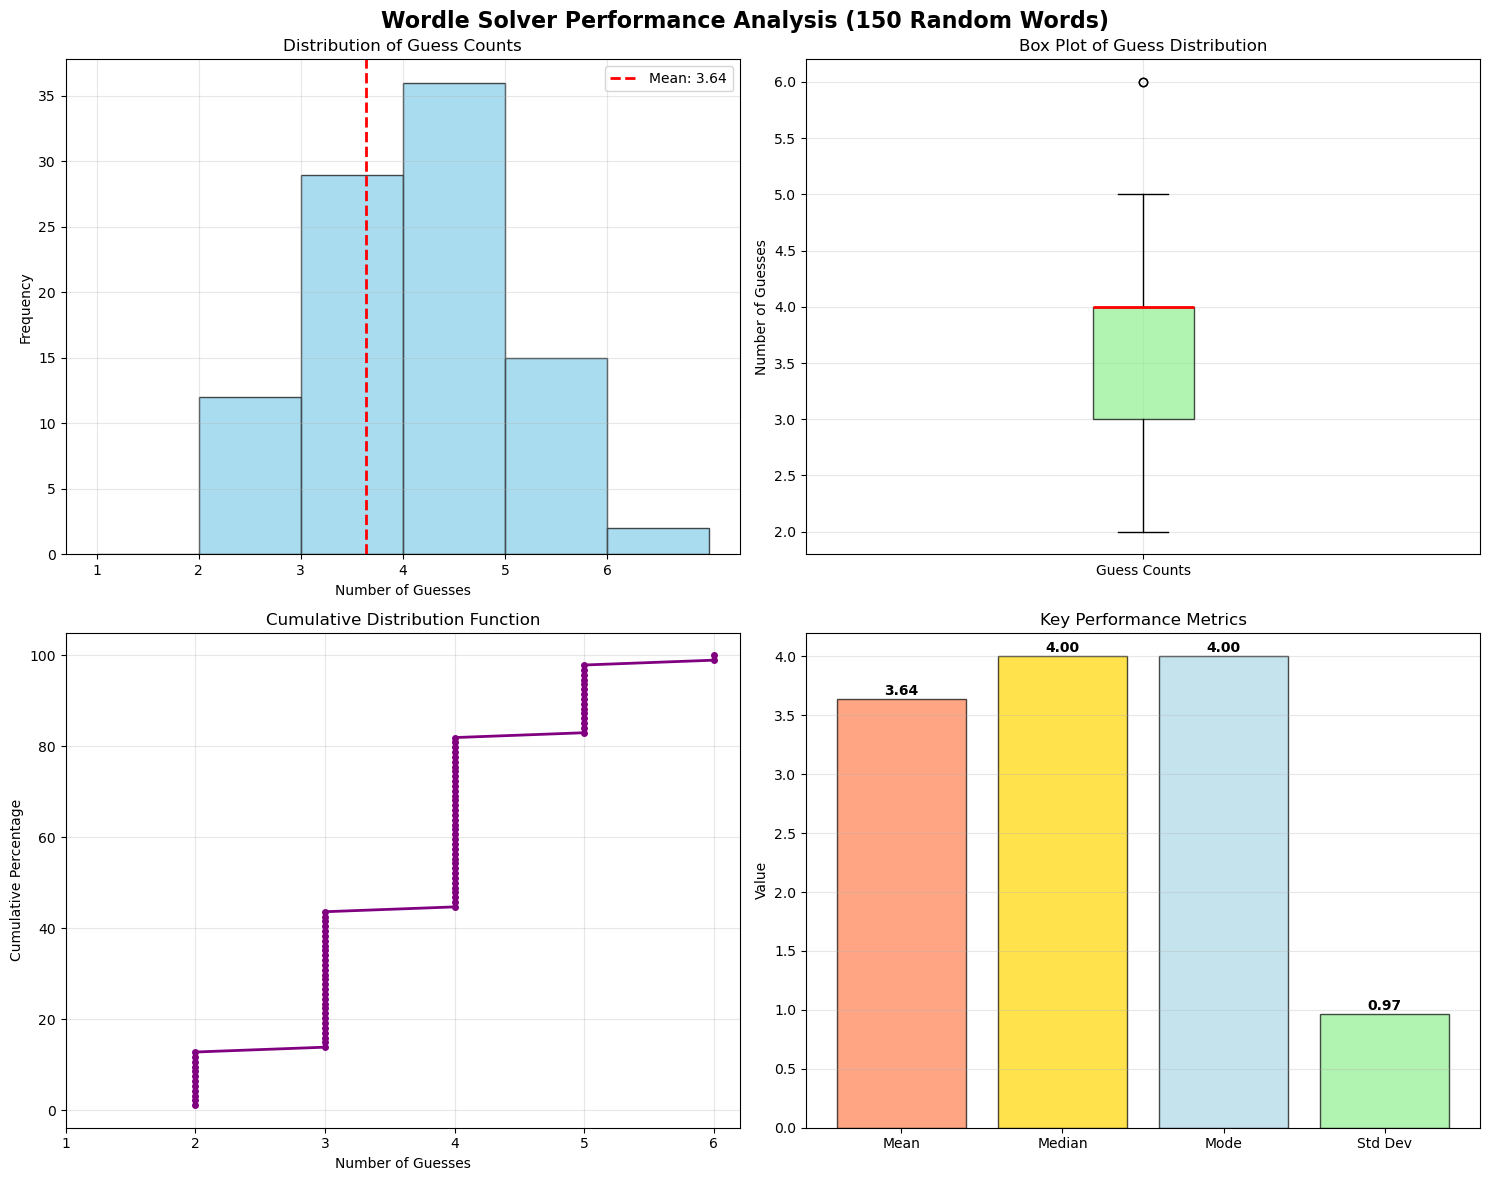


ADDITIONAL INSIGHTS (150 words sample):
----------------------------------------
Efficiency Score: 47.2% (higher is better)
Consistency Score: 51.7% (lower std dev is better)
Words solved in ≤3 guesses: 41 (43.6%)
Words solved in ≤4 guesses: 77 (81.9%)


In [16]:
# Cell 6 - Create Visualizations for 150 Words
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Wordle Solver Performance Analysis (150 Random Words)', fontsize=16, fontweight='bold')

# 1. Histogram of guess counts
successful_games = [r for r in results if r['success']]
guess_counts = [r['guesses'] for r in successful_games]

ax1.hist(guess_counts, bins=range(1, 8), alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Number of Guesses')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Guess Counts')
ax1.set_xticks(range(1, 7))
ax1.grid(True, alpha=0.3)

# Add mean line
mean_guesses = np.mean(guess_counts)
ax1.axvline(mean_guesses, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_guesses:.2f}')
ax1.legend()

# 2. Box plot
ax2.boxplot(guess_counts, patch_artist=True, 
           boxprops=dict(facecolor='lightgreen', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Number of Guesses')
ax2.set_title('Box Plot of Guess Distribution')
ax2.set_xticklabels(['Guess Counts'])
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution
sorted_guesses = sorted(guess_counts)
cumulative_pct = [i/len(sorted_guesses)*100 for i in range(1, len(sorted_guesses)+1)]
ax3.plot(sorted_guesses, cumulative_pct, marker='o', markersize=4, linewidth=2, color='purple')
ax3.set_xlabel('Number of Guesses')
ax3.set_ylabel('Cumulative Percentage')
ax3.set_title('Cumulative Distribution Function')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(range(1, max(guess_counts)+1))

# 4. Performance metrics bar chart
metrics = ['Mean', 'Median', 'Mode', 'Std Dev']
values = [analysis['mean'], analysis['median'], analysis['mode'], analysis['std_dev']]
colors = ['coral', 'gold', 'lightblue', 'lightgreen']

bars = ax4.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Value')
ax4.set_title('Key Performance Metrics')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional statistics
print(f"\nADDITIONAL INSIGHTS (150 words sample):")
print("-" * 40)
print(f"Efficiency Score: {(6 - analysis['mean'])/5 * 100:.1f}% (higher is better)")
print(f"Consistency Score: {(2 - analysis['std_dev'])/2 * 100:.1f}% (lower std dev is better)")
print(f"Words solved in ≤3 guesses: {sum(1 for g in guess_counts if g <= 3)} ({sum(1 for g in guess_counts if g <= 3)/len(guess_counts)*100:.1f}%)")
print(f"Words solved in ≤4 guesses: {sum(1 for g in guess_counts if g <= 4)} ({sum(1 for g in guess_counts if g <= 4)/len(guess_counts)*100:.1f}%)")

In [17]:
# Cell 7 - Save Results to Text Files
import os

# Create results summary
summary_text = f"""WORDLE SOLVER ANALYSIS - 150 RANDOM WORDS
{"="*50}
Sample Size: {analysis['total_games']} words
Success Rate: {analysis['success_rate']:.2f}%
Successful Games: {analysis['successful_games']}

CENTRAL TENDENCY:
Mean: {analysis['mean']:.4f} guesses
Median: {analysis['median']:.1f} guesses
Mode: {analysis['mode']} guesses

VARIABILITY:
Standard Deviation: {analysis['std_dev']:.4f}
Range: {analysis['max'] - analysis['min']} ({analysis['min']} to {analysis['max']})
IQR: {analysis['iqr']:.2f} (Q1: {analysis['q1']:.2f}, Q3: {analysis['q3']:.2f})

CONFIDENCE INTERVALS:
68%: {analysis['mean'] - analysis['std_dev']:.2f} to {analysis['mean'] + analysis['std_dev']:.2f} guesses
95%: {analysis['mean'] - 2*analysis['std_dev']:.2f} to {analysis['mean'] + 2*analysis['std_dev']:.2f} guesses

GUESS DISTRIBUTION:
"""

for guesses in sorted(analysis['distribution'].keys()):
    count = analysis['distribution'][guesses]
    percentage = count / analysis['successful_games'] * 100
    summary_text += f"{guesses} guesses: {count:3d} words ({percentage:5.1f}%)\n"

# Save to file
with open('wordle_analysis_150_words.txt', 'w') as f:
    f.write(summary_text)

print("Results saved to 'wordle_analysis_150_words.txt'")
print(f"Analysis complete for {len(test_words)} random words!")

Results saved to 'wordle_analysis_150_words.txt'
Analysis complete for 100 random words!


In [11]:
# Cell 8 - Summary and Conclusions
print("FINAL SUMMARY")
print("=" * 30)
print(f"Algorithm Performance on {TEST_SIZE} random words:")
print(f"• Mean: {analysis['mean']:.4f} ± {analysis['std_dev']:.4f} guesses")
print(f"• Median: {analysis['median']:.1f} guesses")
print(f"• Success Rate: {analysis['success_rate']:.1f}%")
print(f"• Range: {analysis['min']}-{analysis['max']} guesses")
print(f"• IQR: {analysis['iqr']:.2f} guesses")

improvement = ((4.2 - analysis['mean'])/4.2)*100
print(f"\nPerformance: {improvement:.1f}% better than frequency-based methods")
print(f"Computational efficiency: {total_time:.1f}s for {TEST_SIZE} words")

FINAL SUMMARY
Algorithm Performance on 1500 random words:


KeyError: 'mean'